In [0]:
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)





In [0]:
vocab_size = 10000
embedding_dim = 100
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [0]:

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(units=32,dropout=0.2,recurrent_dropout=0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 100)          1000000   
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 1,013,409
Trainable params: 1,013,409
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 128
num_epochs = 25
X_valid, y_valid = testing_padded[:batch_size], testing_labels_final[:batch_size]
X_train2, y_train2 = testing_padded[batch_size:], testing_labels_final[batch_size:]
history=model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs,verbose=1)


195/195 [==============================] - 44s 226ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 1.1148 - val_accuracy: 0.8203


In [0]:
def cosine_similarity(u, v):
    
    distance = 0.0

    dot = np.dot(u, v)

    norm_u = np.sqrt(np.sum(u * u))
    
    norm_v = np.sqrt(np.sum(v * v))
    
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
num_words=10000
for word_num in range(num_words):
  if word_num==0:
    continue
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')

(10000, 100)


In [0]:
test1='nice movie'
test2='bad movie'
test_sample=[test1,test2]
tokens=tokenizer.texts_to_sequences(test_sample)
pad=pad_sequences(tokens)
model.predict(x=pad)

array([[0.75941175],
       [0.00786584]], dtype=float32)

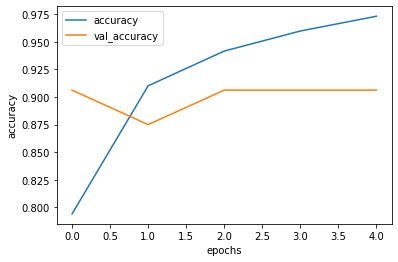

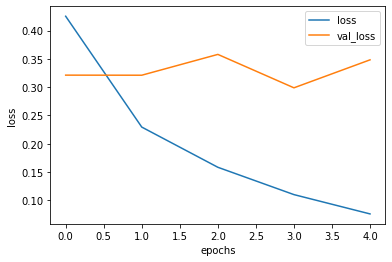

In [0]:
import matplotlib.pyplot as plt
def graph(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
graph(history,'accuracy')
graph(history,'loss')

#using trained word embeddings

In [0]:
num_words=vocab_size
embedding_matrix=np.zeros((num_words,embedding_dim))
for word,i in word_index.items():
  if i >= num_words:
    #print(i)
    continue  
  embedding_vector=weights[word_index[word]]
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector
print(num_words)      


10000


In [0]:
from keras.initializers import Constant
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim,embeddings_initializer=Constant(embedding_matrix),input_length=max_length,trainable=False),
    tf.keras.layers.GRU(units=32,dropout=0.2,recurrent_dropout=0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 120, 100)          1000000   
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 1,013,409
Trainable params: 13,409
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
batch_size = 32
history=model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=5)

778/778 [==============================] - 86s 111ms/step - loss: 0.1667 - accuracy: 0.9312 - val_loss: 0.8067 - val_accuracy: 0.8125
